In [1]:
import sys # for automation and parallelisation
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])
if manual:
    %matplotlib inline

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from quetzal.model import stepmodel
from quetzal.analysis import analysis
from quetzal.engine.pathfinder import PublicPathFinder
from quetzal.io.display import all_pt_paths
from syspy.skims import skims
from quetzal.io import excel

# Preparation of the LoS tables
## Saves a StepModel with shortest paths and LoS attributes for the PT network
## Needs aggregated PT networks

In [3]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [4]:
# Load scenario parameters
params = excel.read_var(file='../input/parameters.xls', scenario=scenario)

In [5]:
sm = stepmodel.read_json(model_path + 'de_pt_network_agg')
ae = stepmodel.read_json(model_path + 'de_pt_access_egress')
aux = stepmodel.read_json(model_path + 'de_pt_network_ancillary')

In [6]:
sm.centroids = ae.centroids
sm.footpaths = ae.footpaths
sm.zone_to_transit = ae.zone_to_transit

In [7]:
sm.links.shape

(271089, 10)

### Prepare links for pathfinder

In [8]:
# aggregate local bus and tram, underground, ferry, funicular
if 'subway' in sm.links['route_type'].unique():
    sm.links['route_type_disagg'] = sm.links['route_type'].copy()
    sm.links['route_type'] = sm.links['route_type'].replace(
        {'tram': 'bus', 'subway': 'bus', 'ferry': 'bus', 'funicular': 'bus'})
    sm.pt_route_types = list(sm.links['route_type'].unique())

In [9]:
# Route types without headway
sm.links.loc[sm.links['headway'].isna()].groupby('route_type').agg({'a': 'count'})

,a
route_type,


In [10]:
sm.links['headway'] = sm.links['headway'].fillna(2*3600)

In [11]:
# Set a maximum headway
for mode in sm.pt_route_types:
    mask = sm.links['route_type']==mode
    sm.links.loc[mask, 'headway'] = np.minimum(
        sm.links.loc[mask, 'headway'], params['max_headway'][mode])

In [12]:
sm.links['headway'] = sm.links['headway'].astype(int)

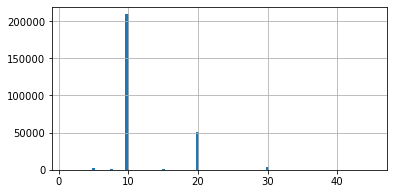

In [13]:
# Waiting time distribution in minutes
if manual: (sm.links['headway']/60/2).hist(bins=100, figsize=(6,3), log=False)

In [14]:
sm.links['headway'].mean()/60/2

12.140801298958399

In [15]:
# Set a mode-specific transfer penalty
# It will be substracted later
time_dict = params['transfer_penalty']
sm.links['boarding_time'] = sm.links['route_type'].map(time_dict) # in s

In [16]:
# Generate length for PT links
if 'length' not in sm.links.columns:
    sm.links['length'] = skims.distance_from_geometry(sm.links['geometry']).astype(int)
    # Adjust coach transport towards road distances
    sm.links.loc[sm.links['route_type']=='coach', 'length'] *= 1.136

In [17]:
sm.links.sample()

,route_type,route_type_disagg,geometry,a,b,link_sequence,route_id,time,trip_id,headway,boarding_time,length
index,,,,,,,,,,,,
rs_60358,rail_short,rail_short,"LINESTRING (13.32954 52.47765, 13.31182 52.48004)",rs_DE300_126,rs_DE300_97,4,rs_98,96,rs_98_6,2400,0,1229.0


In [18]:
# Delete footpaths between centroids as they might confuse the pathfinder
# Add them later anew
sm.footpaths = sm.footpaths.loc[~((sm.footpaths['a'].isin(sm.centroids.index)) |
                                  (sm.footpaths['b'].isin(sm.centroids.index)) |
                                  (sm.footpaths['a']==sm.footpaths['b']))]

<AxesSubplot:>

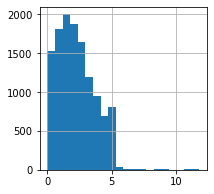

In [19]:
(sm.footpaths['time']/60).hist(bins=20, figsize=(3,3))

### Apply PT pathfinder
It generates the LoS table with shortest paths for each origin destination pair

In [20]:
# We don't want the algorithm to search paths for all mode combinations.
# Thus, we have to extract the pathfinder and search them manually.
ppf = PublicPathFinder(sm)

In [21]:
# Now, build custom mode combinations
# People just don't go by coach and then switch to rail or airplane within Germany
ppf.build_mode_combinations(mode_column='route_type')
#ppf.mode_combinations = [x for x in ppf.mode_combinations
#                         if not ('coach' in x and
#                         ('rail_long' in x or
#                          'rail_short' in x or
#                          'air' in x))]
ppf.mode_combinations

[{'air', 'bus', 'coach', 'rail_long', 'rail_short'},
 {'air', 'bus', 'coach', 'rail_long'},
 {'air', 'bus', 'coach', 'rail_short'},
 {'air', 'bus', 'coach'},
 {'air', 'bus', 'rail_long', 'rail_short'},
 {'air', 'bus', 'rail_long'},
 {'air', 'bus', 'rail_short'},
 {'air', 'bus'},
 {'air', 'coach', 'rail_long', 'rail_short'},
 {'air', 'coach', 'rail_long'},
 {'air', 'coach', 'rail_short'},
 {'air', 'coach'},
 {'air', 'rail_long', 'rail_short'},
 {'air', 'rail_long'},
 {'air', 'rail_short'},
 {'air'},
 {'bus', 'coach', 'rail_long', 'rail_short'},
 {'bus', 'coach', 'rail_long'},
 {'bus', 'coach', 'rail_short'},
 {'bus', 'coach'},
 {'bus', 'rail_long', 'rail_short'},
 {'bus', 'rail_long'},
 {'bus', 'rail_short'},
 {'bus'},
 {'coach', 'rail_long', 'rail_short'},
 {'coach', 'rail_long'},
 {'coach', 'rail_short'},
 {'coach'},
 {'rail_long', 'rail_short'},
 {'rail_long'},
 {'rail_short'},
 set()]

In [22]:
# Load OD pairs from volumes if available
od_set = None
try:
    v = stepmodel.read_json(model_path + 'de_volumes')
    od_set = set([tuple(l) for l in v.volumes[['origin', 'destination']].values.tolist()])
    print('Generated OD set with {} pairs'.format(len(od_set)))
except:
    print('The volumes file is not (yet) available')

Generated OD set with 160801 pairs


In [22]:
# Run the pathfinder for all mode combinations
# If there is no boarding time column in links table:
# Include a transfer penalty in order to promote direct routes.
# It will be substracted later
# The penalty must be None, if a link boarding time is set
transfer_penalty = None
ppf.find_broken_mode_paths(cutoff=np.inf,
                           od_set=od_set,
                           mode_column='route_type',
                           boarding_time=transfer_penalty)

breaking modes: set() : 100%|██████████████████████████████████████████████████████████| 32/32 [01:27<00:00,  2.73s/it]


In [23]:
ppf.broken_mode_paths.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes
161,DE300,DE600,10848.274230,"[DE300, b_DE300_186, rs_DE300_45, rs_23097, rs...",False,mode_breaker,"{coach, bus, rail_long, air}"
161,DE300,DE600,8903.568913,"[DE300, rl_DE300_2, rl_1568, rl_1569, rl_DE600...",False,mode_breaker,"{rail_short, coach, bus, air}"
161,DE300,DE600,8903.568913,"[DE300, rl_DE300_2, rl_1868, rl_1869, rl_DE600...",False,mode_breaker,"{coach, bus, air}"
161,DE300,DE600,43616.105994,"[DE300, c_n_FLIXBUS:1, c_111, c_n_FLIXBUS:30, ...",False,mode_breaker,"{rail_short, rail_long, bus, air}"
161,DE300,DE600,10848.274230,"[DE300, b_DE300_186, rs_DE300_45, rs_23097, rs...",False,mode_breaker,"{rail_long, bus, air}"
161,DE300,DE600,8903.568913,"[DE300, rl_DE300_2, rl_1568, rl_1569, rl_DE600...",False,mode_breaker,"{rail_short, bus, air}"
161,DE300,DE600,8903.568913,"[DE300, rl_DE300_2, rl_1568, rl_1569, rl_DE600...",False,mode_breaker,"{bus, air}"
161,DE300,DE600,29596.709413,"[DE300, c_n_FLIXBUS:1, b_DE300_153, bus_205759...",False,mode_breaker,"{rail_short, rail_long, coach, air}"
161,DE300,DE600,10848.274230,"[DE300, b_DE300_186, rs_DE300_45, rs_23097, rs...",False,mode_breaker,"{rail_long, coach, air}"
161,DE300,DE600,8903.568913,"[DE300, rl_DE300_2, rl_1568, rl_1569, rl_DE600...",False,mode_breaker,"{rail_short, coach, air}"


In [26]:
# Run the path analysis and assign paths as LoS table
sm.pt_los = analysis.path_analysis_od_matrix(
    od_matrix=ppf.broken_mode_paths,
    links=sm.links,
    nodes=sm.nodes,
    centroids=sm.centroids)

path_analysis: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [00:00<?, ?it/s]


In [26]:
print(len(sm.pt_los.index))
sm.pt_los.loc[sm.pt_los['origin']!=sm.pt_los['destination']].sample(3)

3946110


,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,link_path,footpaths,ntlegs,transfers,boarding_links,alighting_links,all_walk,ntransfers,time_link_path,length_link_path
95552,DE94F,DE261,21528.904085,"[DE94F, b_DE94F_85, bus_1102341, b_DE94D_421, ...",False,mode_breaker,"{air, coach, rail_short}","[b_DE94F_85, b_DE94D_421, b_DE94D_8, b_DE94D_1...","[b_DE94D_421, b_DE94D_8, b_DE94D_11, b_DE941_6...","[b_DE94F_85, b_DE94D_421, b_DE94D_8, b_DE94D_1...","[bus_1102341, bus_1426684, bus_1426685, bus_23...","[(b_DE941_60, rl_DE941_0)]","[(DE94F, b_DE94F_85), (rl_DE261_0, DE261)]","[b_DE94D_421, b_DE94D_8, b_DE94D_11, rl_DE263_0]","[bus_1102341, bus_1426684, bus_238007, bus_152...","[bus_1102341, bus_1426685, bus_238007, bus_152...",False,5,14280,542179.0
154545,DEG09,DE502,16012.250748,"[DEG09, rs_DEG09_2, rs_51428, rs_51429, rs_514...",False,mode_breaker,"{air, coach, bus}","[rs_DEG09_2, rl_DE91C_0, rs_DE501_0]","[rs_DE91C_2, rl_DE501_0, rs_DE502_2]","[rs_DEG09_2, rs_DE91C_2, rl_DE91C_0, rl_DE501_...","[rs_51428, rs_51429, rs_51430, rl_1694, rl_169...","[(rs_DE91C_2, rl_DE91C_0), (rl_DE501_0, rs_DE5...","[(DEG09, rs_DEG09_2), (rs_DE502_2, DE502)]",[],"[rs_51428, rl_1694, rs_28542]","[rs_51430, rl_1695, rs_28543]",False,2,10560,306304.0
150973,DEF0E,DE912,17739.432162,"[DEF0E, rs_DEF0E_4, rs_26208, rs_26209, rs_262...",False,mode_breaker,"{rail_long, coach}","[rs_DEF0E_4, rs_DE600_5, rs_DE929_6, b_DE91A_1...","[rs_DE600_5, rs_DE929_6, rs_DE91A_2, b_DE91A_6...","[rs_DEF0E_4, rs_DE600_5, rs_DE929_6, rs_DE91A_...","[rs_26208, rs_26209, rs_26210, rs_26211, rs_26...","[(rs_DE91A_2, b_DE91A_124)]","[(DEF0E, rs_DEF0E_4), (b_DE912_94, DE912)]","[rs_DE600_5, rs_DE929_6, b_DE91A_64]","[rs_26208, rs_54266, rs_9145, bus_200263, bus_...","[rs_26215, rs_54279, rs_9149, bus_200263, bus_...",False,4,11460,282821.0


### Add attributes to LoS table

In [27]:
# Drop within-cell connections
sm.pt_los = sm.pt_los.loc[sm.pt_los['link_path'].apply(lambda l: len(l)>0)]
sm.pt_los.shape

(3933278, 20)

In [27]:
# Add distances (Only path, not access/egress)
len_dict = sm.links['length'].to_dict()
sm.pt_los['length'] = sm.pt_los['link_path'].apply(lambda p: sum([len_dict[l] for l in p]))

In [28]:
# Disaggregate time into in-vehicle and access/egress
# Substract the transfer penalty set above (put 0)
if transfer_penalty is None:
    sm.analysis_pt_time(boarding_time=None)
    sm.pt_los['time'] -= sm.pt_los['boarding_time']
#    sm.pt_los['boarding_time'] = 0
else:
    sm.analysis_pt_time(boarding_time=0)
sm.pt_los.columns

Index(['origin', 'destination', 'gtime', 'path', 'reversed',
       'pathfinder_session', 'broken_modes', 'boardings', 'alightings',
       'node_path', 'link_path', 'footpaths', 'ntlegs', 'transfers',
       'boarding_links', 'alighting_links', 'all_walk', 'ntransfers',
       'time_link_path', 'length_link_path', 'length', 'access_time',
       'footpath_time', 'in_vehicle_time', 'waiting_time', 'boarding_time',
       'time'],
      dtype='object')

In [31]:
# Check times
sm.pt_los[['ntransfers', 'length']+[c for c in sm.pt_los.columns if c[-4:]=='time']].sample(2)

,ntransfers,length,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
140094,3,176267.0,10349.462725,1382.388928,147.073797,5220,3000.0,0,9749.462725
2486,2,245341.0,14890.488542,578.297712,32.190831,10680,2400.0,0,13690.488542


In [29]:
# Add route_types
type_dict = sm.links['route_type'].to_dict()
sm.pt_los['route_types'] = [set([type_dict[link] for link in l])
                            for l in list(sm.pt_los['link_path'])]

In [30]:
# Add main route_type based on a hierarchy
hierarchy = ['air', 'coach', 'rail_long', 'rail_short', 'bus', 'walk']
def main_type(types):
    t = hierarchy[-1]
    try:
        t = hierarchy[min([hierarchy.index(t) for t in types])]
    except ValueError: # empty types set
        pass
    return t
sm.pt_los['route_type'] = sm.pt_los['route_types'].apply(main_type)

In [31]:
# Substract the waiting time at the first stop
headway_dict = sm.links['headway'].to_dict()
mask = sm.pt_los['route_type']!='air'
sm.pt_los.loc[mask, 'time'] -= sm.pt_los.loc[mask, 'link_path'].apply(
    lambda l: l[0]).map(headway_dict) / 2
sm.pt_los.loc[mask, 'waiting_time'] -= sm.pt_los.loc[mask, 'link_path'].apply(
    lambda l: l[0]).map(headway_dict) / 2

In [34]:
# Add price, parametrisation comes later because
# our GTFS feeds come without fares
sm.pt_los['price'] = 0

In [35]:
sm.pt_los.sample()

,origin,destination,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,node_path,...,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_types,route_type,price
25780,DE21L,DE263,15157.449677,"[DE21L, rs_DE21L_4, rs_17042, rs_17043, rs_DE2...",False,mode_breaker,"{air, rail_long, bus}","[rs_DE21L_4, rs_DE212_30, rs_DE254_0]","[rs_DE212_21, rs_DE254_0, rs_DE263_0]","[rs_DE21L_4, rs_DE212_21, rl_DE212_0, rs_DE212...",...,275170.0,1041.971416,135.478261,10380,2400.0,0,13957.449677,{rail_short},rail_short,0


In [36]:
# Make a safety copy before restricting results
if manual: los = sm.pt_los.copy()

In [37]:
#sm.pt_los = los.copy()

### Clean PT LOS

In [38]:
# Drop duplicates
sm.pt_los['path'] = sm.pt_los['path'].apply(tuple)
sm.pt_los.drop_duplicates('path', inplace=True)
sm.pt_los.reset_index(drop=True, inplace=True)
sm.pt_los.shape

(1994447, 30)

In [32]:
# Berlin - Hamburg
all_pt_paths(sm, 'DE300', 'DE600', verbose=False, group_name='route_type')

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 16.18it/s]


In [40]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
56160,0,267282.000,{rail_short},"[rs_23097, rs_23098, rs_23099, rs_23100, rs_23...",10848.274230,1058.144262,70.129968,8520,0.0,0,9648.274230
170296,0,253129.000,{rail_long},"[rl_1868, rl_1869]",8903.568913,1043.568914,0.000000,6060,0.0,0,7103.568914
330538,2,786893.568,{coach},"[c_108, c_672, c_673, c_674, c_675, c_676, c_8...",43616.105994,1016.105994,0.000000,41700,600.0,0,43316.105994
425469,0,253129.000,{rail_long},"[rl_1568, rl_1569]",8903.568913,1043.568914,0.000000,6060,0.0,0,7103.568914
554239,28,503117.000,{bus},"[bus_2057590, bus_2057591, bus_2057592, bus_20...",29596.709413,1047.334501,79.374912,11070,16800.0,0,28996.709413
1028689,28,503117.000,{bus},"[bus_2057590, bus_2057591, bus_2057592, bus_20...",29596.709413,1047.334501,79.374912,11070,16800.0,0,28996.709413
1402540,2,926486.920,"{air, coach}","[air_60, c_551, c_552, c_553, c_554, c_880, c_...",33682.007365,873.072470,708.934895,28800,600.0,0,30982.007365
1520068,28,503117.000,{bus},"[bus_2057590, bus_2057591, bus_2057592, bus_20...",29596.709413,1047.334501,79.374912,11070,16800.0,0,28996.709413
1801496,28,503117.000,{bus},"[bus_2057590, bus_2057591, bus_2057592, bus_20...",29596.709413,1047.334501,79.374912,11070,16800.0,0,28996.709413


In [41]:
# Drop trips with coach-rail or coach-air combinations
sm.pt_los = sm.pt_los.loc[~sm.pt_los['route_types'].apply(
    lambda x: 'coach' in x and ('rail_long' in x or 'rail_short' in x))]
sm.pt_los.shape

(1816026, 30)

In [42]:
'''# Drop trips with air interchange
sm.pt_los.drop(sm.pt_los.loc[(sm.pt_los['route_type']=='air') &
                             (sm.pt_los['link_path'].apply(
                                 lambda x: len([t for t in x if type_dict[t]=='air'])>1))
                            ].index, inplace=True)'''
sm.pt_los.shape

(1816026, 30)

In [43]:
# Drop unrealistically long trips
sm.pt_los = sm.pt_los.loc[sm.pt_los['in_vehicle_time']<params['clean_los']['max_duration']]
sm.pt_los.shape

(1771015, 30)

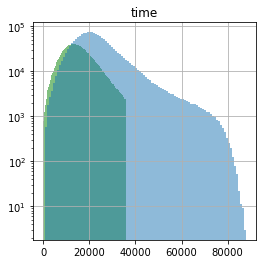

In [44]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=True, alpha=.5))

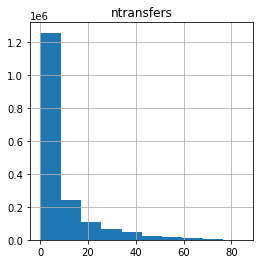

In [45]:
if manual: sm.pt_los.hist(column='ntransfers', figsize=(4,4))

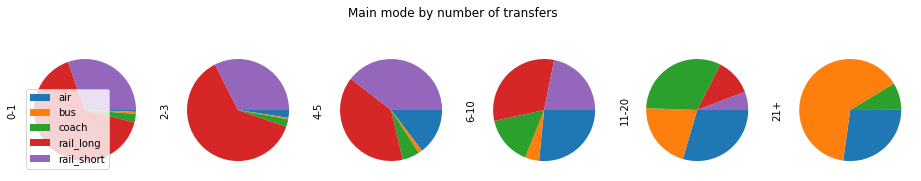

In [46]:
# Main mode distribution by transfers
if manual:
    t = sm.pt_los.copy()
    t['bins'] = pd.cut(t['ntransfers'], bins=[0,1,3,5,10,20,100],
                       labels=["0-1", "2-3","4-5","6-10","11-20","21+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by number of transfers',
        legend=False, labeldistance=None)
    axs[0].legend(loc='lower left')

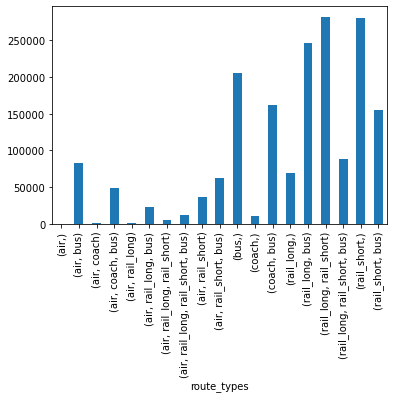

In [47]:
# Distribution of mode combinations
if manual:
    t['route_types'] = t['route_types'].apply(tuple)
    t.groupby('route_types').count()['route_type'].plot(kind='bar')

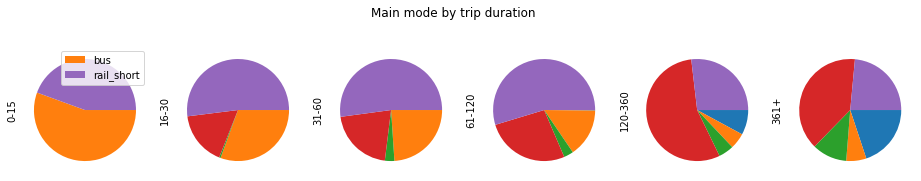

In [48]:
if manual:
    t['time'] = t['time'] / 60
    t['bins'] = pd.cut(t['time'], bins=[0,15,30,60,120,360,500],
                       labels=["0-15", "16-30","31-60","61-120","120-360","361+"])
    axs = t.groupby(['route_type','bins']).size().unstack(fill_value=0).plot.pie(
        subplots=True, figsize=(16, 3),
        startangle=0, counterclock=False, title='Main mode by trip duration',
        legend=False, labeldistance=None)
    axs[0].legend()

In [49]:
if manual: t = None

In [50]:
# Drop unnecessary long connections if there is a waiting time applied
if sm.links['headway'].mean() > 1*60:
    sm.pt_los = sm.pt_los.loc[sm.pt_los['ntransfers']<=
                              params['clean_los']['max_transfers']]
    # Drop coach connections with more than one transfer
    sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                                (sm.pt_los['boardings'].apply(
                                    lambda l: len([n for n in l if n.startswith('c')])>2)
                                ))]
sm.pt_los.shape

(1171842, 30)

In [51]:
# Keep only the fastest trip(s)
sm.pt_los['route_types'] = sm.pt_los['route_types'].apply(tuple)
sm.pt_los = sm.pt_los.sort_values('time').groupby(
    ['origin', 'destination', 'route_types']).nth(
        list(range(params['clean_los']['n_fastest_trips']))).reset_index()
sm.pt_los.shape

(627004, 30)

In [52]:
# Bus tickets are relatively cheap, but they apply only for short distances
# And nobody books tickets at five different bus agencies
# Thus, drop bus trips longer than 100km
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='bus') &
                            (sm.pt_los['length']>params['clean_los']['max_dist_bus']))]
sm.pt_los.shape

(625077, 30)

In [53]:
# Also drop coach trips for local transport
sm.pt_los = sm.pt_los.loc[~((sm.pt_los['route_type']=='coach') &
                            (sm.pt_los['length']<params['clean_los']['min_dist_coach']))]
sm.pt_los.shape

(624913, 30)

In [54]:
# Keep only trips where in-vehicle-time makes at least a third
#sm.pt_los = sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3]
#sm.pt_los.shape
len(sm.pt_los.loc[sm.pt_los['time']<sm.pt_los['in_vehicle_time']*3])

621090

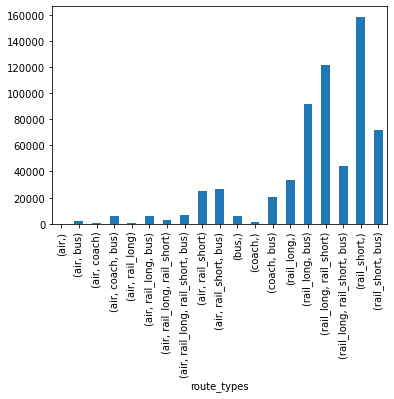

In [55]:
if manual: sm.pt_los.groupby('route_types').count()['route_type'].plot(kind='bar')

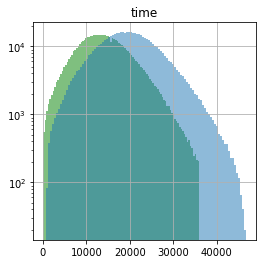

In [56]:
# Time distribution
if manual:
    sm.pt_los.hist(column='time', bins=100, log=True, alpha=.5,
                   ax=sm.pt_los.hist(column='in_vehicle_time', color='green',
                                     bins=100, figsize=(4,4), log=True, alpha=.5))

In [57]:
# Look at Berlin - Hamburg times
sm.pt_los.loc[(sm.pt_los['origin']=='DE300')&(sm.pt_los['destination']=='DE600')][
    ['ntransfers', 'length', 'route_types', 'link_path']+[c for c in sm.pt_los.columns if c[-4:]=='time']]

,ntransfers,length,route_types,link_path,gtime,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time
204215,2,926486.92,"(air, coach)","[air_60, c_551, c_552, c_553, c_554, c_880, c_...",33682.007365,873.072470,708.934895,28800,600.0,0,30982.007365
204216,0,253129.00,"(rail_long,)","[rl_1868, rl_1869]",8903.568913,1043.568914,0.000000,6060,0.0,0,7103.568914
204217,0,267282.00,"(rail_short,)","[rs_23097, rs_23098, rs_23099, rs_23100, rs_23...",10848.274230,1058.144262,70.129968,8520,0.0,0,9648.274230


In [58]:
# Stuttgart and surrounding?
sm.pt_los.loc[(sm.pt_los['origin']=='DE112')&(sm.pt_los['destination']=='DE111')]

,origin,destination,route_types,gtime,path,reversed,pathfinder_session,broken_modes,boardings,alightings,...,length_link_path,length,access_time,footpath_time,in_vehicle_time,waiting_time,boarding_time,time,route_type,price
1371,DE112,DE111,"(bus,)",3037.691403,"(DE112, b_DE112_46, bus_1449393, b_DE112_16, b...",False,mode_breaker,"{air, rail_long, coach, rail_short}","[b_DE112_46, b_DE112_16, b_DE111_181]","[b_DE112_16, b_DE111_181, b_DE111_200]",...,15408.0,15408.0,1226.596243,71.095161,240,900.0,0,2437.691403,bus,0
1372,DE112,DE111,"(rail_long,)",4254.524097,"(DE112, b_DE112_102, rl_DE112_1, rl_3555, rl_D...",False,mode_breaker,"{air, coach, rail_short, bus}",[rl_DE112_1],[rl_DE111_0],...,16857.0,16857.0,1140.956405,53.567691,1260,0.0,0,2454.524097,rail_long,0
1373,DE112,DE111,"(rail_short,)",2832.242806,"(DE112, b_DE112_102, rs_DE112_1, rs_39526, rs_...",False,mode_breaker,"{air, rail_long, coach, bus}",[rs_DE112_1],[rs_DE111_11],...,9405.0,9405.0,1226.596243,165.646563,540,0.0,0,1932.242806,rail_short,0


In [59]:
assert len(sm.pt_los.loc[sm.pt_los.isna().any(axis=1)])==0

## Save model

In [60]:
# Ditch unneccessary columns
to_drop = ['gtime', 'path', 'reversed', 'pathfinder_session',
           'broken_modes', 'boardings', 'alightings', 'node_path',
           'footpaths', 'ntlegs', 'transfers', 'boarding_links',
           'alighting_links', 'all_walk', 'time_link_path',
           'length_link_path', 'boarding_time', 'index']
sm.pt_los = sm.pt_los.drop(to_drop, axis=1, errors='ignore')

In [61]:
# Clean links table
to_drop = ['duration', 'cost', 'origin', 'destination']
sm.links = sm.links.drop(to_drop, axis=1, errors='ignore')

In [62]:
# Make table smaller
cols = ['time', 'access_time', 'in_vehicle_time', 'footpath_time',
        'waiting_time', 'length']
sm.pt_los[cols] = sm.pt_los[cols].astype(int)

In [63]:
sm.pt_los.sample()

,origin,destination,route_types,link_path,ntransfers,length,access_time,footpath_time,in_vehicle_time,waiting_time,time,route_type,price
60335,DE149,DE21K,"(rail_long, rail_short)","[rs_44625, rs_44626, rs_44627, rs_44628, rs_44...",1,262845,2181,26,10200,1800,14207,rail_long,0


In [64]:
# Saving LoS...
sm.to_json(model_path + 'de_pt_los', only_attributes=['pt_los'],
           encoding='utf-8')

to_hdf(overwriting): 100%|█████████████████████████████████████████████████████████████| 35/35 [00:23<00:00,  1.47it/s]
